# Effects of Weather Events on Flight Delays and Cancellations

## Introduction

This project seeks to form a causal relationship of weather events on the frequency of commercial airline flight delays and cancellations. Flight data was compiled from the Bureau of Transportation Statistics website; weather events were taken from a Kaggle webpag [https://www.kaggle.com/sobhanmoosavi/us-weather-events] based on the paper "Short and Long-term Pattern Discovery Over Large-Scale Geo-Spatiotemporal Data" by Moosavi, et al. All flights in 2016-2019 from the busiest 24 airports in 2018, and the weather events in those cities, were selected.

## Data Fields

The data required extensive preprocessing before analysis; details can be found in the Exploratory Data Analysis (EDA) writeup. Processed data can be found in the `departure_events.csv` file. The origin city and departure date uniquely identify each record. All other fields represent the daily summary of each airport. `departure_events.csv` has the following columns:

* ORIGIN: Three-letter IATA airport code
* DepartureDate: Date of the flights' departures
* ArrivDelay: Arriving flights delayed
* DepartDelay: Departing flights delayed
* Flights: Total departing flights
* WeatherCancelled: Departing flights cancelled due to weather
* WeatherDelayed: Departing flights delayed due to weather
* Cold: Whether the daily temperature dropped below -10.7 F (0 or 1)
* Fog: Presence of fog (0, 1=Light, 2=Heavy)
* Hail: Presence of hail (0 or 1)
* Wind: Wind over 40 mph (0 or 1)
* Rain: Presence of rain (0, 1=Light, 2=Medium, 3=Heavy)
* Sleet: Presence of sleet (0 or 1). Note: The paper did not distinguish between hail and sleet; this had to be done manually. Details are given in the EDA writeup.
* Snow: Presence of snow (0, 1=Light, 2=Medium, 3=Heavy)
* FracCancelled: Fraction of the departing flights cancelled due to weather
* FracDelayed: Fraction of the departing flights delayed due to weather
* Month: Numerical month of the year (1-12)
* Season: (Winter, Spring, Summer, Fall)
* Region: Region of the country based on the location of the airport (West, Midwest, Northeast, South, Florida)

Several of these columns will be removed during this step of the process.

## Exploratory Data Analysis

Before we do any training on the data, let's look at what the data is telling us.

In [1]:
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
save_plots = True; save_plots = False #whether to save the resulting plots
pd.options.mode.chained_assignment = None #turns off warnings for data replacements

CODES = ['Cold','Fog','Hail','Wind','Rain','Sleet','Snow']
DEPARTURES = 0; ARRIVALS = 1; PATHS = 2
YELLOW_HIGHLIGHT = (1.0, 1.0, 0.5)
stopwatch = TimeTracker.TimeTracker()

In [3]:
'''For each missing hour in the 24-hour day, introduce one undelayed, uncancelled flight.
We need those "flights" to avoid dividing by zero later.'''
def fill_hourly_gaps(hourly_summary):
    origin_dest = hourly_summary.columns[0] #'ORIGIN' or 'DEST'
    for airport in AIRPORTS:
        for year in range(min(hourly_summary.Year), max(hourly_summary.Year)+1):
            hours_missing = np.setdiff1d(
                np.arange(24), hourly_summary.loc[(
                    hourly_summary[origin_dest] == airport)
                    & (hourly_summary.Year == year)].Hour.to_numpy())
            n = len(hours_missing)
            new_rows = pd.DataFrame([n*[airport], n*[year], hours_missing, n*[1], n*[0], n*[0]],
                                    index=hourly_summary.columns).transpose()
            # print(airport, year, hours_missing)
            hourly_summary = pd.concat([new_rows, hourly_summary])
    return hourly_summary.sort_values([origin_dest, 'Year', 'Hour'], ignore_index=True)

In [4]:
'''Set the portion of flights per day cancelled and delayed, and groups them by period.
dataset: Whether these are departures(0), arrivals(1), or paths(2) (both).'''
def get_periodic_summaries(df, case, period='Month'):
    df['Flights'] = 1 #for portions
    paths_case = case==PATHS
    categories = [
        ['Flights', 'ORIGIN', 'DepartureTime', 'WeatherDelayed', 'WeatherCancelled'],
        ['Flights', 'DEST', 'ArrivalTime', 'WeatherDelayed', 'WeatherCancelled'],
        ['Flights', 'ORIGIN', 'DEST', 'DepartureTime', 'WeatherDelayed', 'WeatherCancelled']][case]
    df = df[categories]
    if period=='Month':
        df[period] = df[[categories[2], 'DepartureTime'][paths_case]].str[5:7].astype(int)
    elif period=='Hour':
        df[period] = df[[categories[2], 'DepartureTime'][paths_case]].str[11:13].astype(int)        
    else:
        raise ValueError('function not equipped for period ', period)
    df['Year'] = df[[categories[2], 'DepartureTime'][paths_case]].str[:4].astype(int)
    summary = df.groupby([[categories[1], 'Year', period],
                          ['ORIGIN', 'DEST', 'Year', period]][paths_case]).sum().reset_index()
    # A couple of flights left on 12/31/2019 and arrived on 1/01/2020. Delete that arrival group.
    if case==ARRIVALS:
        summary = summary[summary.Year < 2020]
    return summary

In [5]:
'''An individual plot within the summary plot. The df needs to be a Nx2 array of
delay rates and then cancellation rates. vertLines==True only tested with period=='Hour'.'''
def indiv_plot(ax, df, title, xlabel, ylabel, period, normalize, ymax, vertLines,
               case, lastcol=4, xticklabelsize=7, MiamiMarkers=False):
    trimInterval = [0, 24]
    if period=='Month':
        x = np.arange(1, len(MONTHS)+1)
    elif period=='Hour': #Any remaining value for period will result in an error.
        x = np.arange(24)
        ax.set_xlim([0, 24+1e-5])
    if vertLines: #Only tested when period=='Hour'
        lw = 1; ls = '--'; color='k'
        # Departures: 5 AM - 10 PM. Arrivals: 6 AM - 12 AM.
        trimInterval = [[5, 22], [6, 24]][case]
        x = np.arange(trimInterval[0], trimInterval[1])
        ax.plot(2*[trimInterval[0]], [0, ymax], lw=lw, ls=ls, c=color, zorder=-2)
        ax.plot(2*[trimInterval[1]-1], [0, ymax], lw=lw, ls=ls, c=color, zorder=-2)
    if df is not None:
        if normalize:
            ax.plot(x, 100*df.iloc[trimInterval[0]:trimInterval[1], lastcol-1],
                    color='b', lw=3, ls='--', label='Delays')
            ax.plot(x, 100*df.iloc[trimInterval[0]:trimInterval[1], lastcol],
                    color='r', lw=2.5, label='Cancellations')
        else:         
            ax.plot(x, df['Flights'], color='k', lw=2, label='No. of Flights')
    if MiamiMarkers:
        #Determine whether this is a case of a summer peak or lull.
        summerPeak = (np.max(df.WeatherDelayed.iloc[5:8] >= 0.025))
        x_marker = 7 #July
        y_marker = 100*df.WeatherDelayed.iloc[int(round(x_marker))-1] #rounded just in case
        if summerPeak:
            ax.add_patch(Ellipse((x_marker, y_marker), width=4, height=2, lw=0.5))
        else:
            print(df.WeatherDelayed)
            end_height = 0.8 + y_marker
            print(end_height)
            arrow_length = 1
            ax.arrow(x_marker, end_height+arrow_length, 0, -arrow_length, color='k',
                     width=0.5, head_width=1.5, head_length=0.5, overhang=0.4, zorder=5)
    
    x -= trimInterval[0]
    if period=='Hour':
        x = np.arange(25) # to reset the x ticks to the full 24 hour scale
    ax.set_title(title, fontsize=12)
    ax.set_xticks([x, x[::6]][period=='Hour'])
    if period=='Month':
        ax.set_xticklabels(MONTHS, fontsize=xticklabelsize)
    elif period=='Hour':
        ax.set_xticklabels(['12 AM', '6 AM', '12 PM', '6 PM', '12 AM'], fontsize=xticklabelsize)
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.set_ylim([0,ymax])
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    return ax

In [6]:
def periodic_summary_by_airport(
        periodic_departures, periodic_arrivals, period='Month', delaysCancels=True,
        normalize=True, highlightMiami=True, vertLines=False):
    nrows, ncols = 2, 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
    fig.subplots_adjust(hspace=0.2, wspace=[0.4, 0.2][normalize], bottom=0.16, top=0.83)
    for i in range(nrows):
        airport_summaries = [periodic_departures, periodic_arrivals][i].groupby(
            [['ORIGIN','DEST'][i], period]).sum().drop(['Year'], axis=1).reset_index()
        for j in range(ncols):
            airport = AIRPORTS[j]
            df = airport_summaries[airport_summaries[['ORIGIN','DEST'][i]]==airport]
            if normalize:
                df['WeatherDelayed'] /= df.Flights
                df['WeatherCancelled'] /= df.Flights
            ylabel = ['', ['Departure','Arrival'][i] + ['s', ' %'][normalize]][j==0]
            MiamiMarkers = (airport=='MIA' and highlightMiami)
            ax = indiv_plot(axs[i, j], df=df, title=['', airport_names_map[airport]][i==0],
                            xlabel=['', period][i==nrows-1], ylabel=ylabel, period=period,
                            normalize=normalize, ymax=[6e3, 5][normalize], vertLines=vertLines, case=i,
                            MiamiMarkers=MiamiMarkers)
            if MiamiMarkers: #Highlight departure/arrival delay discrepancy
                ax.set_facecolor(YELLOW_HIGHLIGHT)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, borderaxespad=0.5)
    fig.suptitle(period + 'ly ' + ['Flights','Weather Delays and Cancellations'][delaysCancels]\
                 + ' by Airport', fontsize=16)
    if save_plots:
        plt.savefig(period + 'lySummariesByAirport.png')
    plt.show()

In [7]:
'''Plot of statistics per route.'''
def periodic_summary_by_route(periodic_routes, period='Month', normalize=True):
    nrows = ncols = 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.2, bottom=0.16, top=0.9)
    for i in range(nrows):
        dest = AIRPORTS[i]
        for j in range(ncols):
            origin = AIRPORTS[j]
            if j == i:
                df = None
            else:
                df = periodic_routes[(periodic_routes.ORIGIN==origin) & (periodic_routes.DEST==dest)]\
                    .groupby([period]).sum().drop(['Year'], axis=1).reset_index()
                df['WeatherDelayed'] /= df.Flights #Normalization
                df['WeatherCancelled'] /= df.Flights
            MiamiMarkers = ('MIA' in [origin, dest]) & ('ATL' not in [origin, dest]) & (origin != dest)
            ax = indiv_plot(
                axs[i, j], df=df, title=['', 'From ' + origin][i==0], 
                xlabel=['', period][i==nrows-1], ylabel=['', 'To ' + dest][j==0],
                period=period, normalize=normalize, ymax=6, vertLines=False, case=None, lastcol=3,
                MiamiMarkers=MiamiMarkers)
            if MiamiMarkers:
                ax.set_facecolor(YELLOW_HIGHLIGHT)
        if i==0 and j==nrows-1:
            handles, labels = ax.get_legend_handles_labels()
    fig.suptitle('Percent of Weather Delays and Cancellations by Route', fontsize=16)
    fig.legend(handles, labels, loc='lower center', ncol=2, borderaxespad=1)
    if save_plots:
        plt.savefig(period + 'lySummariesByAirport.png')
    plt.show()

## Data collection

In [8]:
# Get the weather data.
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)

print('Importing flight data')
flight_data = pd.read_csv('flights_with_weather.csv')

# Get airport names, which are written manually to allow for name customization.
airport_names_map = {'ATL':'Atlanta', 'JFK':'New York JFK', 'MIA':'Miami', 'ORD':"Chicago O'Hare"}
flight_data['DepAirport'] =  flight_data.ORIGIN.map(airport_names_map)
flight_data['ArrAirport'] =  flight_data.DEST.map(airport_names_map)

monthly_arrivals = get_periodic_summaries(flight_data, case=ARRIVALS)
monthly_departures = get_periodic_summaries(flight_data, case=DEPARTURES)
monthly_routes = get_periodic_summaries(flight_data, case=PATHS)

Importing flight data


## Summary plots

24    0.027731
25    0.017374
26    0.006971
27    0.009311
28    0.006714
29    0.016057
30    0.017493
31    0.011245
32    0.005553
33    0.002542
34    0.008553
35    0.016740
Name: WeatherDelayed, dtype: float64
2.5493311380942583


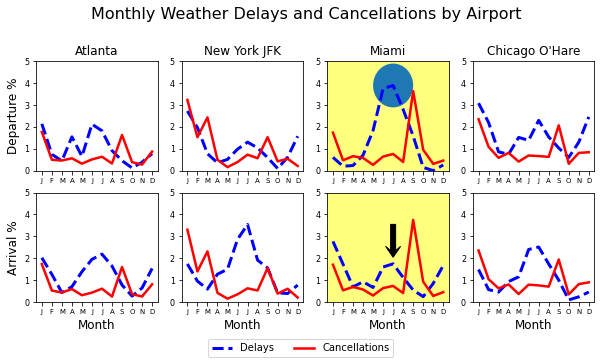

In [9]:
# Plot arrivals and departure monthly summaries over each airport
MONTHS = list('JFMAMJJASOND')
AIRPORTS = list(airport_names_map.keys())
    
periodic_summary_by_airport(monthly_departures, monthly_arrivals)

Contrary to what we would expect, there are some significant differences between departure and arrival
delays and cancellations. Miami has many more departure delays than arrival delays in the summer, and a
lesser but reversed effect is true at JFK. Miami is known for having frequent thunderstorms during the
summer; perhaps they affect the departure process more than the arrival process. Also notice that there
is a large cancellation spike for Miami in September. This was likely caused by Hurricane Irma in September
2017, which shut down Miami International Airport. Because our weather does not account for actual
hurricanes, if we left these cancelled flights in, the model would associate the heavy rain and wind with
a lot of cancellations here. Therefore, we should remove them.

In [10]:
# Locate Hurricane Irma dates for Miami (around 09/10/2017)
miami_sept_2017 = flight_data[((flight_data.ORIGIN == 'MIA') | (flight_data.DEST == 'MIA')) & (
    flight_data.DepartureTime.str[:10] > '2017-09-06') & (flight_data.DepartureTime.str[:10] < '2017-09-17')]
miami_sept_2017['Day'] = miami_sept_2017.DepartureTime.str[8:10].astype(int)
miami_summary = (miami_sept_2017.groupby(['Day']).sum().reset_index())[[
    'Day','Flights','WeatherDelayed','WeatherCancelled']]
miami_summary['CancelledFrac'] = miami_summary.WeatherCancelled/miami_summary.Flights
print('September 2017 cancellations in Miami:\n', miami_summary[['Day', 'CancelledFrac']])

September 2017 cancellations in Miami:
    Day  CancelledFrac
0    7       0.075758
1    8       0.573529
2    9       1.000000
3   10       1.000000
4   11       1.000000
5   12       0.250000
6   13       0.191176
7   14       0.078947
8   15       0.118421
9   16       0.132353


In [11]:
# The hardest hit days were between Sep. 8-13, 2017, including a complete shutdown Sep. 9-11. Drop those dates.
dates_dep = flight_data.DepartureTime.str[:11]
dates_arr = flight_data.ArrivalTime.str[:11]
flights_to_drop = flight_data[((flight_data.ORIGIN == 'MIA') | (flight_data.DEST == 'MIA')) & (
    dates_dep > '2017-09-07') & (dates_dep < '2017-09-14') & (dates_arr > '2017-09-07') & (
        dates_arr < '2017-09-14')].index
flight_data.drop(flights_to_drop, inplace=True)
del(miami_summary, miami_sept_2017, dates_arr, dates_dep, flights_to_drop) #No longer needed

24    0.027731
25    0.017374
26    0.006971
27    0.009311
28    0.006714
29    0.016057
30    0.017493
31    0.011245
32    0.005166
33    0.002542
34    0.008553
35    0.016740
Name: WeatherDelayed, dtype: float64
2.5493311380942583


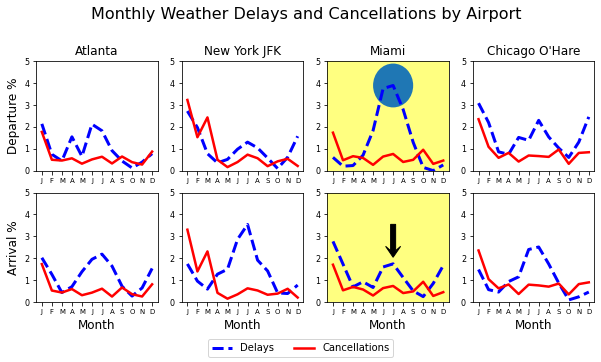

In [12]:
# Let's see what the plots look like now.
monthly_arrivals = get_periodic_summaries(flight_data, case=ARRIVALS)
monthly_departures= get_periodic_summaries(flight_data, case=DEPARTURES)
monthly_routes = get_periodic_summaries(flight_data, case=PATHS)
periodic_summary_by_airport(monthly_departures, monthly_arrivals)

Miami's September spikes are gone. Notice that the other airports also lose some smaller spikes caused
by the flights that were scheduled to and from Miami during Hurricane Irma.

Let's see if there are any more particular trends between the airports. We construct another, 4x4 plot of
delay and cancellation rates from each of our four airports to each other airport.

0     0.020000
1     0.019366
2     0.008696
3     0.000812
4     0.000805
5     0.004988
6     0.008078
7     0.007194
8     0.001730
9     0.000000
10    0.005159
11    0.013428
Name: WeatherDelayed, dtype: float64
1.6077544426494346
0     0.040391
1     0.028229
2     0.010210
3     0.007397
4     0.015246
5     0.014989
6     0.023432
7     0.016243
8     0.008994
9     0.006369
10    0.016393
11    0.028002
Name: WeatherDelayed, dtype: float64
3.1432115782219165


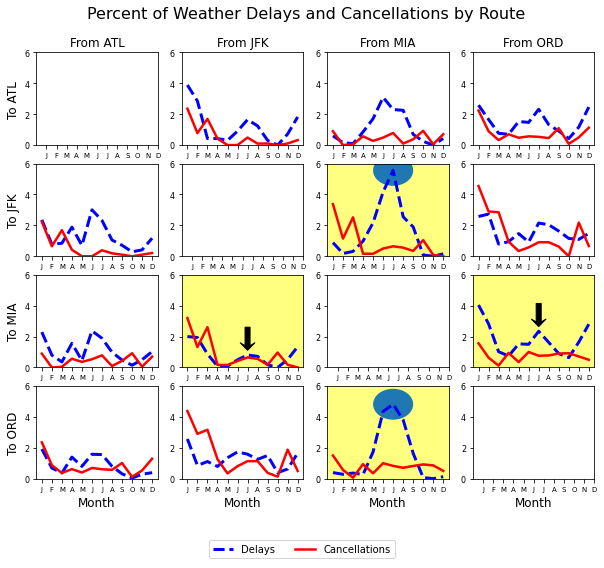

In [13]:
periodic_summary_by_route(monthly_routes)

The asymetry between departure and arrival delays is now spread around the individual routes.
For instance, the lack of symmetry between Miami's departure weather delays to JFK and O'Hare and
arrival delays from them is stark. The lack of this effect at the other three airports suggest this
is an actual issue with delays from Miami International Airport and not a bug in the data. However,
the cancellation data is nearly symmetric, suggesting that when flights are cancelled due to
weather, both departing and arriving flights are cancelled.

Now let's see if there is a correlation between time of day and delays/cancellations.

In [14]:
hourly_departures = get_periodic_summaries(flight_data, case=DEPARTURES, period='Hour')
hourly_arrivals = get_periodic_summaries(flight_data, case=ARRIVALS, period='Hour')

Some hours of the day, particularly early in the morning, have no scheduled flights. The graph
cannot be set up without these missing time spots. The following method fills them.

In [15]:
print('Filling zero-flight hours in hourly summaries')
hourly_departures = fill_hourly_gaps(hourly_departures)
hourly_arrivals = fill_hourly_gaps(hourly_arrivals)

Filling zero-flight hours in hourly summaries


Let's see when these lack of flights take place.

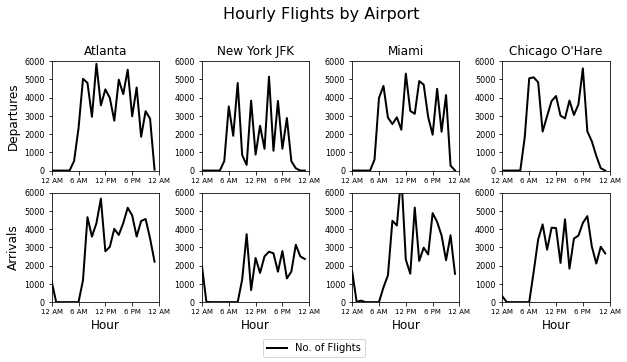

In [16]:
periodic_summary_by_airport(hourly_departures, hourly_arrivals, period='Hour',
                            delaysCancels=False, normalize=False, highlightMiami=False)

In general, flights depart between 5 AM - 11 PM and arrive between 6 AM - midnight. Very few of
our flights are scheduled to depart or arrive outside of these timeframes. Note that this timeframe
is somewhat shorter for JFK, possibly due to flight time restrictions.

We will visually denote these times on the next set of charts: Hourly delay and cancellation rates,
per airport, categorized by arrivals and departures.

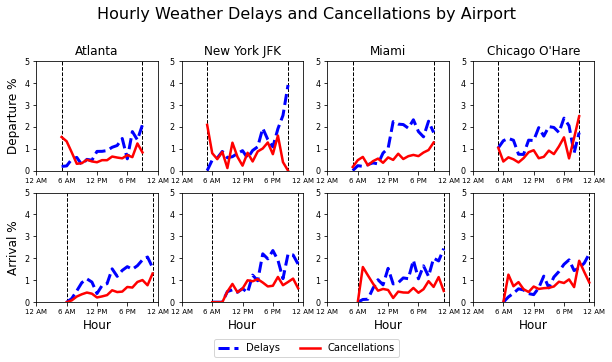

In [17]:
periodic_summary_by_airport(hourly_departures, hourly_arrivals, period='Hour',
                            highlightMiami=False, vertLines=True)

As explained above, the spikes for Miami's arrivals and Atlanta's and Chicago's departures
occur during a window of very few flights and should be taken with a grain of salt. Note that
both departure and arrival delay percentages are uncommon in the morning but increase as the
day goes on; this effect is much sharper for Miami's departures after 12 PM. The overall pattern
is probably due to both thunderstorms' being more common in the afternoon and airports' runway
capacity being reduced during heavy rains.

## Data Analysis

### General analysis

Let's start by doing a t-test of Miami's delays. We will compare Miami's PM departures to
its AM departures.

In [18]:
MIA_AM_departures = flight_data[flight_data.ORIGIN == 'MIA'].loc[:, ['DepartureTime','WeatherDelayed']]
MIA_AM_departures['Afternoon'] = MIA_AM_departures.DepartureTime.str[11:13] < '12' #11:13 = hour
MIA_PM_departures = MIA_AM_departures[MIA_AM_departures.Afternoon]
MIA_AM_departures = MIA_AM_departures[~MIA_AM_departures.Afternoon]

print(ttest_ind(MIA_AM_departures.WeatherDelayed, MIA_PM_departures.WeatherDelayed, equal_var=False))

Ttest_indResult(statistic=19.05892036513864, pvalue=1.0157020283107905e-80)


Though we can't depend too much on p-values, with a p-value that strong it is extremely likely that
this result--more of Miami's departures are delayed than arrivals--is statistically significant. This matches
our suspicion of summertime afternoon thunderstorms causing many of Miami's delays.

In [19]:
'''Logistic regression with significance testing.
input_columns: list of column NUMBERS.
response_column: column NAME.'''
def logreg(df, input_columns, response_column, maxiter=200):
    y = df[response_column]
    X = sm.add_constant(df.iloc[:,input_columns])
    return sm.Logit(y, X).fit(maxiter=maxiter)

In [20]:
'''Get the list of the weather columns used as explanatory variables.'''
def specify_weather_cols(df, column_list):
    weather_cols = df.columns.get_indexer_for(column_list)
    return range(weather_cols[0], weather_cols[1]+1) #need to include the last column!

In [21]:
# Print the full list of columns in flight_data to make sure we have this right.
print('\nColumns of flight_data:\n' + str(flight_data.dtypes))


Columns of flight_data:
ORIGIN                 object
DEST                   object
WeatherDelayLength    float64
WeatherCancelled        int64
WeatherDelayed          int64
DepartureTime          object
ArrivalTime            object
DepCold                 int64
DepHail                 int64
DepSleet                int64
DepWind                 int64
DepFog                float64
DepSnow               float64
DepRain               float64
ArrCold                 int64
ArrHail                 int64
ArrSleet                int64
ArrWind                 int64
ArrFog                float64
ArrSnow               float64
ArrRain               float64
DepAirport             object
ArrAirport             object
Flights                 int64
dtype: object


In [22]:
# Several columns are floats that can be strings. Let's fix that.
float_to_int = ['DepFog', 'DepSnow', 'DepRain', 'ArrFog', 'ArrSnow', 'ArrRain']
flight_data[float_to_int] = flight_data[float_to_int].astype(int)

# Copy the flight data so that we can individually choose which rows to drop.
flight_data_for_cancellations = flight_data.drop([
    'ORIGIN', 'DEST', 'DepAirport', 'ArrAirport', 'DepartureTime', 'ArrivalTime', 'WeatherDelayLength'],axis=1)
flight_data_for_delays = flight_data_for_cancellations.drop('WeatherCancelled', axis=1)
flight_data_for_cancellations.drop('WeatherDelayed', axis=1, inplace=True)

Do a linear regression on the data. Technically we require a normality assumption, but
a t-distribution approaches a normal distribution as the sample size becomes large, and we
certainly have that (over 200k rows and just 14 explanatory variable colummns). There are
four sets of explanatory-response variables to analyze:
X: Departure weather, y: departure delays
X: Departure weather, y: departure cancellations
X: Arrival weather, y: arrival delays
X: Arrival weather, y: arrival cancellations

Note: We are copy-pasting instead of using a for loop for Jupyter.

In [23]:
print('\nLogistic regression analysis: Delays')
weather_cols = specify_weather_cols(flight_data, ['DepCold','ArrRain'])
lr = logreg(flight_data, input_columns=weather_cols, response_column='WeatherDelayed')
print(lr.summary())


Logistic regression analysis: Delays
         Current function value: 0.059964
         Iterations: 200


D:\Users\Barrett\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:         WeatherDelayed   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214971
Method:                           MLE   Df Model:                           14
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                  0.1002
Time:                        13:51:36   Log-Likelihood:                -12891.
converged:                      False   LL-Null:                       -14327.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8649      0.026   -189.985      0.000      -4.915      -4.815
DepCold        2.3161      0.383      6.054      0.000       1.566       3.066
DepHail        1.5730      0.751      2.094      0.0

In [24]:
print('\nLogistic regression analysis: Cancellations')
lr = logreg(flight_data, input_columns=weather_cols, response_column='WeatherCancelled')
print(lr.summary())


Logistic regression analysis: Cancellations
Optimization terminated successfully.
         Current function value: 0.036549
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:       WeatherCancelled   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214971
Method:                           MLE   Df Model:                           14
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                  0.1408
Time:                        13:51:38   Log-Likelihood:                -7857.5
converged:                       True   LL-Null:                       -9145.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4726      0.034   -158.655      0.000      -5

Our initial results are disappointing. The p-values are small, but the fit() method didn't converge.

Let's start with the departures. All the individual codes, possibly except for DepHail on
cancellations, have extremely small p-values. Perhaps we need to include a square term for
the codes that can have more than two values. We can also drop ArrHail because of its high
p-value in both tables (note: we retain ArrFog for now because it is being squared).

In [25]:
flight_data[['DepFogSqu', 'DepRainSqu', 'DepSnowSqu', 'ArrFogSqu', 'ArrRainSqu', 'ArrSnowSqu']]\
    = np.square(flight_data[['DepFog', 'DepRain', 'DepSnow', 'ArrFog', 'ArrRain', 'ArrSnow']])

In [26]:
# Rearrange the columns to make the columns more readable.
flight_data = flight_data[flight_data.columns.sort_values()]
print(flight_data.columns)
first_columns = ['ORIGIN','DEST','DepAirport','ArrAirport','DepartureTime','ArrivalTime']
flight_data = flight_data[first_columns + [col for col in flight_data.columns if col not in first_columns]]
print(flight_data.columns)
# Much better. Now let's reanalyze with the square columns included and ArrHail dropped.

Index(['ArrAirport', 'ArrCold', 'ArrFog', 'ArrFogSqu', 'ArrHail', 'ArrRain',
       'ArrRainSqu', 'ArrSleet', 'ArrSnow', 'ArrSnowSqu', 'ArrWind',
       'ArrivalTime', 'DEST', 'DepAirport', 'DepCold', 'DepFog', 'DepFogSqu',
       'DepHail', 'DepRain', 'DepRainSqu', 'DepSleet', 'DepSnow', 'DepSnowSqu',
       'DepWind', 'DepartureTime', 'Flights', 'ORIGIN', 'WeatherCancelled',
       'WeatherDelayLength', 'WeatherDelayed'],
      dtype='object')
Index(['ORIGIN', 'DEST', 'DepAirport', 'ArrAirport', 'DepartureTime',
       'ArrivalTime', 'ArrCold', 'ArrFog', 'ArrFogSqu', 'ArrHail', 'ArrRain',
       'ArrRainSqu', 'ArrSleet', 'ArrSnow', 'ArrSnowSqu', 'ArrWind', 'DepCold',
       'DepFog', 'DepFogSqu', 'DepHail', 'DepRain', 'DepRainSqu', 'DepSleet',
       'DepSnow', 'DepSnowSqu', 'DepWind', 'Flights', 'WeatherCancelled',
       'WeatherDelayLength', 'WeatherDelayed'],
      dtype='object')


In [27]:
flight_data.drop('ArrHail', axis=1, inplace=True)

print('\nLogistic regression analysis: Delays')
weather_cols = specify_weather_cols(flight_data, ['ArrCold','DepRainSqu'])
lr = logreg(flight_data, input_columns=weather_cols, response_column='WeatherDelayed')
print(lr.summary())


Logistic regression analysis: Delays
         Current function value: 0.062539
         Iterations: 200


D:\Users\Barrett\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:         WeatherDelayed   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214970
Method:                           MLE   Df Model:                           15
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                 0.06155
Time:                        13:51:53   Log-Likelihood:                -13445.
converged:                      False   LL-Null:                       -14327.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7883      0.026   -184.402      0.000      -4.839      -4.737
ArrCold        1.9466      0.516      3.770      0.000       0.935       2.959
ArrFog        -1.0058      0.833     -1.207      0.2

In [28]:
print('\nLogistic regression analysis: Cancellations')
lr = logreg(flight_data, input_columns=weather_cols, response_column='WeatherCancelled')
print(lr.summary())


Logistic regression analysis: Cancellations
Optimization terminated successfully.
         Current function value: 0.038773
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:       WeatherCancelled   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214970
Method:                           MLE   Df Model:                           15
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                 0.08852
Time:                        13:51:55   Log-Likelihood:                -8335.6
converged:                       True   LL-Null:                       -9145.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3471      0.034   -157.833      0.000      -5

The cancellation analysis converges faster, but the pseudo-R-squared value is reduced.

The delay analysis shows very little improvement. It could be that a logistic regression even with squared
variables is not a reliable way of classifying this data. However, the p-values of the
individual variables may give us clues going forward as to which varibles to include.

Let's rerun the regressions again without any varible having a p-value of at least 0.01. We will make an
exception for Cancellation' DepSnow and DepSnowSqu. Since we have seen that cancellations for departures and
arrivals are nearly symmetrical, that ArrSnow and ArrSnowSqu ar significant suggests that the departure snow
codes should be as well.

In [29]:
print('\nLogistic regression analysis: Cancellations')
cancel_cols = flight_data.columns.get_indexer([
    'ArrCold','ArrRain','ArrSleet','ArrSnow','ArrSnowSqu','ArrWind','DepCold','DepRain','DepSnow','DepSnowSqu'])
lr = logreg(flight_data, input_columns=cancel_cols, response_column='WeatherCancelled')
print(lr.summary())


Logistic regression analysis: Cancellations
Optimization terminated successfully.
         Current function value: 0.036522
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:       WeatherCancelled   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214975
Method:                           MLE   Df Model:                           10
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                  0.1414
Time:                        13:51:57   Log-Likelihood:                -7851.6
converged:                       True   LL-Null:                       -9145.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5291      0.036   -155.396      0.000      -5.

In [30]:
print('\nLogistic regression analysis with variable set trimmed: Delays')
delay_cols = flight_data.columns.get_indexer(['ArrCold','ArrRain','DepCold','DepHail','DepRain','DepRainSqu'])
lr = logreg(flight_data, input_columns=delay_cols, response_column='WeatherDelayed')
print(lr.summary())


Logistic regression analysis with variable set trimmed: Delays
Optimization terminated successfully.
         Current function value: 0.062717
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:         WeatherDelayed   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214979
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                 0.05889
Time:                        13:51:59   Log-Likelihood:                -13483.
converged:                       True   LL-Null:                       -14327.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7679      0.025   -188.235 

Finally, the delay analysis converges.

The strongest indicator of delays seems to be the presence and intensity of departure rain.
DepCold may have a stronger coefficient, but rain is far more frequent than bitter cold. With
the DepRainSqu code, if all other weather codes are 0, our prediction values for the log of
the odds of a delay are given by the equation

$$f(x) = -0.1849x^2 + 1.4973x - 4.7679$$

where $x \in \{0,1,2,3\}$ is the rain code. Then<br>
<br>
$f(0) = -4.768$<br>$f(1) = -3.456$<br>
$f(2) = -2.513$<br>$f(3) = -1.940$

Setting $g(x) = \exp(f(x))$ gives

$g(0) = 0.00850$<br>$g(1) = 0.03157$<br>
$g(2) = 0.08103$<br>$g(3) = 0.14369$

This means that with all other weather codes zero, a departure rain code value of 1, 2, or 3
yields 3.7 times, 9.5 times, and 17 times the odds of a delay from a departure rain code value
of 0, respectively!

In [31]:
print('\nLogistic regression analysis: Cancellations')
delay_cols = flight_data.columns.get_indexer([
    'ArrCold','ArrRain','ArrSleet','ArrSnow','ArrSnowSqu','ArrWind',
    'DepCold','DepRain','DepSnow','DepSnowSqu'])
lr = logreg(flight_data, input_columns=delay_cols, response_column='WeatherCancelled')
print(lr.summary())


Logistic regression analysis: Cancellations
Optimization terminated successfully.
         Current function value: 0.036522
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:       WeatherCancelled   No. Observations:               214986
Model:                          Logit   Df Residuals:                   214975
Method:                           MLE   Df Model:                           10
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                  0.1414
Time:                        13:52:01   Log-Likelihood:                -7851.6
converged:                       True   LL-Null:                       -9145.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5291      0.036   -155.396      0.000      -5.

Indeed, the departure snow codes matter, and as one would expect, their values are close to those of
the arrival snow codes. Note that we could analyze the higher-coefficient variables such as DepCold and
ArrCold, but there are far fewer nonzero instances of those codes. Then without loss of generality, let's
analyze the odds of a cancellation based on ArrSnow and ArrSnowSqu.

$$f(x) = -0.3893x^2 + 2.2434x - 5.5291$$

where $x \in \{0,1,2,3\}$ is the rain code. Then<br>
<br>
$f(0) = -5.529$<br>$f(1) = -3.675$<br>
$f(2) = -2.600$<br>$f(3) = -2.303$

Setting $g(x) = \exp(f(x))$ gives

$g(0) = 0.00397$<br>$g(1) = 0.02535$<br>
$g(2) = 0.07431$<br>$g(3) = 0.09999$

This means that with all other weather codes zero, an arrival snow code value of 1, 2, or 3 yields 6.4 times,
18.7 times, and 25.2 times the odds of a delay from an arrival snow code value of 0, respectively. The odds of a
flight getting cancelled with an arrival snow code of 3 are 1:10--a probability of 1/11.

Now let's get some F1 scores.

## Classification Reports

In [50]:
lr = LogisticRegression(class_weight='balanced')
y_train = flight_data.WeatherCancelled
X_train = flight_data.iloc[:,cancel_cols]
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_train)[:,1] > 0.95
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    213445
           1       0.17      0.23      0.20      1541

    accuracy                           0.99    214986
   macro avg       0.58      0.61      0.59    214986
weighted avg       0.99      0.99      0.99    214986



In [33]:
lr = LogisticRegression(class_weight='balanced')
y_train = flight_data.WeatherDelayed
X_train = flight_data.iloc[:,delay_cols]
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_train)[:,1] > 0.85
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    212326
           1       0.10      0.30      0.15      2660

    accuracy                           0.96    214986
   macro avg       0.55      0.63      0.57    214986
weighted avg       0.98      0.96      0.97    214986



Despite our efforts and several rounds of tweaing with the prediction probability threshold, the F1 scores for both cancelled and delayed flights' 1 code are low. This model is not able to predict delays and cancellations well. However, it does do a good job of identifying flights that are not delayed nor cancelled.

Let's look at the percentage of flights are delayed or cancelled vs. rain or snow code.

In [34]:
'''Calculates the portion of flights affected per weather code value.'''
def fraction_affected_by_code(df, flight_status_code, weather_code):
    df = df.groupby(weather_code).sum()
    return df[flight_status_code]/df['Flights']

In [35]:
'''Plot the percentage of affected flights, both on the departure and arrival end.'''
def plot_flight_percentages(x, x_offset, y1, y2, flight_event, weather_name):
    fig, ax = plt.subplots()
    ax.bar(x - x_offset/2, 100*y1, width=x_offset, color='b', label='Departures')
    ax.bar(x + x_offset/2, 100*y2, width=x_offset, color='r', label='Arrivals')
    ax.set_title('Percentage of flights ' + flight_event + ' by ' + weather_name)
    ax.set_xlabel('Code value')
    ax.set_ylabel('Percentage')
    ax.set_xticks(codes)
    ax.legend(loc='best')

In [36]:
codes = np.arange(4)
width = 0.35

DepSnowCancelled = fraction_affected_by_code(
    flight_data_for_cancellations, flight_status_code='WeatherCancelled', weather_code='DepSnow')
ArrSnowCancelled = fraction_affected_by_code(
    flight_data_for_cancellations, flight_status_code='WeatherCancelled', weather_code='ArrSnow')
DepSnowDelayed = fraction_affected_by_code(
    flight_data_for_delays, flight_status_code='WeatherDelayed', weather_code='DepSnow')
ArrSnowDelayed = fraction_affected_by_code(
    flight_data_for_delays, flight_status_code='WeatherDelayed', weather_code='ArrSnow')

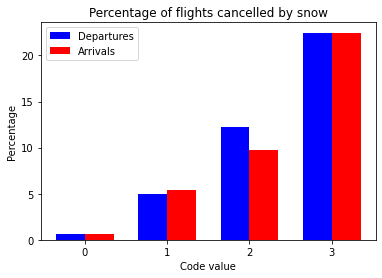

In [37]:
plot_flight_percentages(codes, width, DepSnowCancelled, ArrSnowCancelled, 'cancelled', 'snow')

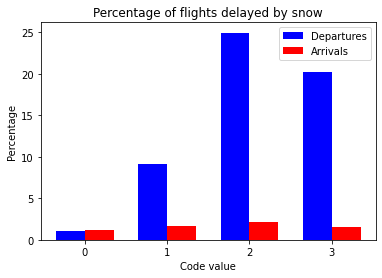

In [38]:
plot_flight_percentages(codes, width, DepSnowDelayed, ArrSnowDelayed, 'delayed', 'snow')

As expected the percentages of flights cancelled by snow on the departure and arrival side
are roughly equal per weather code, but there are significantly more departures delayed by snow
than arrivals. Let's do a logistic regression to see if this is a consistent pattern. Without
loss of generality, we will run this test over just the flights with a snow code value of 2, since there
are many more of them than for a snow code value of 3.

Also notice the decrease in delays from snow code values of 2 to 3. This is probably due to a significant
rise in cancellations. A flight cannot be classified as both delayed and cancelled.

Let's investigate this.

In [39]:
snow_2_departure_delays = flight_data[flight_data.DepSnow == 2]['WeatherDelayed']
snow_2_arrival_delays = flight_data[flight_data.ArrSnow == 2]['WeatherDelayed']
print(ttest_ind(snow_2_departure_delays, snow_2_arrival_delays, equal_var=False))

Ttest_indResult(statistic=9.781760984231372, pvalue=1.1174485481596408e-20)


Again we have statistical significance.

Why are flights more likely to be delayed if their departure airport is experiencing
snow rather than their arrival airport? It could be due to the preparation needed.
Airplanes have to be de-iced during winter weather, a process which takes time and
depends on the amount of equipment available. An airplane does not have to take such
measures when landing in snow; once it lands, it can just proceed to its gate.

Now let's repeat this process for rain.

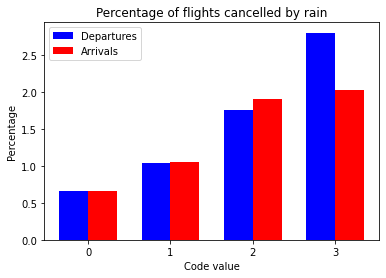

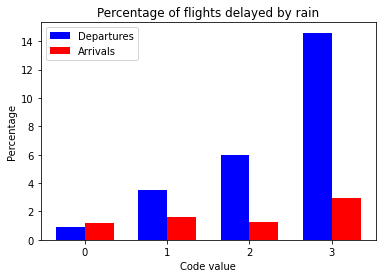

In [40]:
DepRainCancelled = fraction_affected_by_code(
    flight_data_for_cancellations, flight_status_code='WeatherCancelled', weather_code='DepRain')
ArrRainCancelled = fraction_affected_by_code(
    flight_data_for_cancellations, flight_status_code='WeatherCancelled', weather_code='ArrRain')
DepRainDelayed = fraction_affected_by_code(
    flight_data_for_delays, flight_status_code='WeatherDelayed', weather_code='DepRain')
ArrRainDelayed = fraction_affected_by_code(
    flight_data_for_delays, flight_status_code='WeatherDelayed', weather_code='ArrRain')

plot_flight_percentages(codes, width, DepRainCancelled, ArrRainCancelled, 'cancelled', 'rain')
plot_flight_percentages(codes, width, DepRainDelayed, ArrRainDelayed, 'delayed', 'rain')

The departure-arrival split is similar for the rain for both the delays and cancellations.
This time, the rise in arrival delays is steady all the way through a rain code value of 3. Perhaps
airports can still accept arriving airplanes during heavy rain as long as there is no severe
weather, which would force a ground stop.

We need to consider how many of our flights actually have each of these codes. Since the
flights seem much more vulnerable to delays on the departure end, we will focus on arrival codes.

In [41]:
print('Value counts of arrival snow codes:\n' + str(flight_data['ArrSnow'].value_counts().sort_index()))
print('\nValue counts of arrival rain codes:\n' + str(flight_data['ArrRain'].value_counts().sort_index()))

Value counts of arrival snow codes:
0    211799
1      2336
2       409
3       442
Name: ArrSnow, dtype: int64

Value counts of arrival rain codes:
0    192632
1     17710
2      3313
3      1331
Name: ArrRain, dtype: int64


This disparity is one possible source of the problem. Balancing was used in the logistic regressions
above to weight the rows by weather code value (i.e., all the 3's combined were given equal weight to
all the 0's combined), which we see was probably necessary, but that was not sufficient.

Another problem may be the weather data. It would take a long time to set up a webscrape to verify
all our weather data, but we can take a sample.

In [42]:
# del(ArrSnowCancelled, ArrSnowDelayed, DEPARTURES, DepSnowCancelled, MIA_AM_departures,
#     MIA_PM_departures, DepSnowDelayed, X_train, cancel_cols, delay_cols, first_columns,
#     float_to_int, weather_cols, width, snow_2_departure_delays, snow_2_arrival_delays)

In [43]:
print(stopwatch.getElapsedTime())

--- 54.53 seconds ---
